In [ ]:
import numpy as np
import pandas as pd

import random
from collections import Counter
from tqdm.notebook import tqdm

import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
seed = 2023

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Свертки - recap


![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   


Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$


После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность.

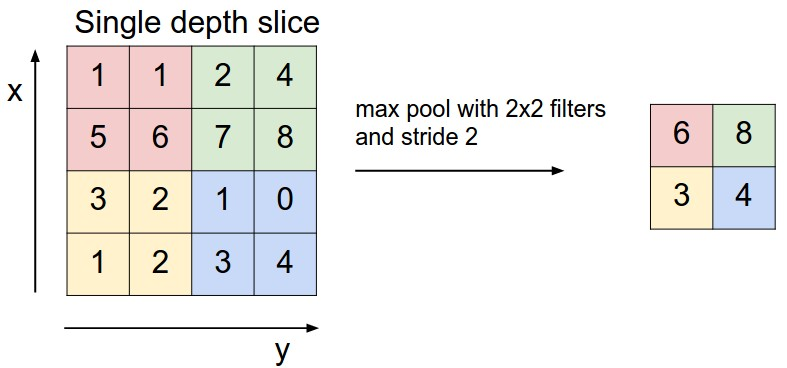

### Character-Level Convolutions

- Создаем char-level эмбеддинги
- Проходимся свертками различной ширины по получившимся эмбеддингам
- Делаем max-pooling == получаем максимум соответствующий той n-грамме, которая наиболее близка к фильтру свертки по косинусному расстоянию


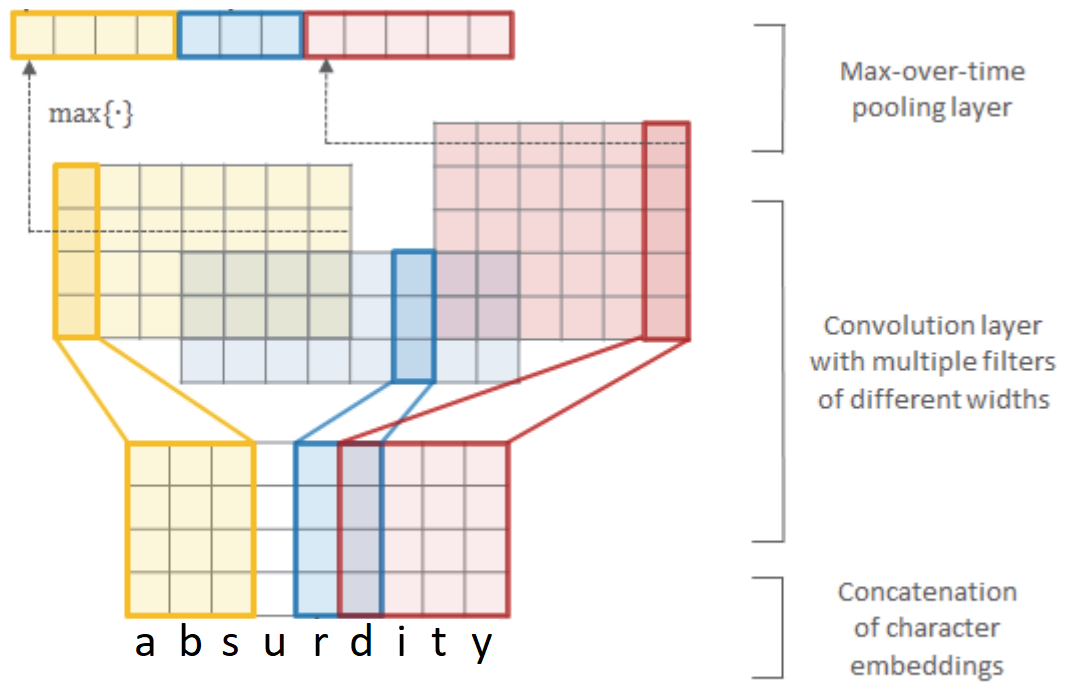

#### Поиск фамилий

In [ ]:
with open('surnames.txt') as f:
  lines = f.readlines()
  data = [line.strip().split('\t')[0].lower() for line in lines]
  labels = np.array([int(line.strip().split('\t')[1]) for line in lines])

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=2023)

In [ ]:
train_data[:15]

['фату',
 'архилох',
 'зверьке',
 'инициалах',
 'полусвета',
 'приводом',
 'герасимов',
 'мотивацией',
 'революция',
 'мартингала',
 'энергоснабжение',
 'больничным',
 'упрощения',
 'специалистка',
 'шаманизме']

In [ ]:
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1

threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word length for 99% of words is 17


In [ ]:
chars = set()
for word in train_data:
    chars.update(word)

char2id = {c : i + 1 for i, c in enumerate(chars)}
char2id['<pad>'] = 0

print(char2id)

{'ъ': 1, 'г': 2, 'т': 3, 'ф': 4, 'п': 5, 'д': 6, 'ь': 7, 'м': 8, 'й': 9, 'ѐ': 10, 'ó': 11, 'к': 12, 'э': 13, '7': 14, 'ч': 15, 'о': 16, 'р': 17, '«': 18, '4': 19, '/': 20, 'ш': 21, 'ю': 22, '»': 23, 'а': 24, '.': 25, 'з': 26, 'х': 27, 'л': 28, 'н': 29, 'ы': 30, '”': 31, 'е': 32, '·': 33, '’': 34, "'": 35, 'я': 36, 'б': 37, '“': 38, ' ': 39, 'ж': 40, '2': 41, 'в': 42, 'ц': 43, 'у': 44, 'и': 45, 'щ': 46, 'с': 47, '-': 48, '3': 49, 'ё': 50, '<pad>': 0}


In [ ]:
class DataWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = []
        for word in data:
          self.data.append([char2id.get(c, 0) for c in word])
        self.labels = labels

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
batch_size = 32
epochs = 10

In [ ]:
class ConvCharClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=30, num_classes=2, out_channel=32, kernels=(2, 3, 4)):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, out_channel, kernel_size=(k, emb_dim)) for k in kernels])
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(len(kernels)*out_channel, num_classes)

    def forward(self, x):
        x = x.permute(1, 0) # bs, len
        x = self.embedding(x) # bs, len, emb_size
        x = x.unsqueeze(1) # bs, 1, len, emb_size
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size()[2]).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [ ]:
model = ConvCharClassifier(vocab_size=len(char2id))
model.train()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
def pad_batch(batch):
    data = [torch.Tensor(item[0]).long() for item in batch]
    data = pad_sequence(data)
    labels = torch.Tensor([item[1] for item in batch]).long()
    return data, labels

**TorchMetrics** is a collection of 90+ PyTorch metrics implementations and an easy-to-use API to create custom metrics.

[torchmetrics](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import F1Score

In [ ]:
train_dataset = DataWrapper(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)

val_dataset = DataWrapper(test_data, test_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)

loss_history = []
f1_scores = []
f1 = F1Score(task="binary").cuda()

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss, temp_metrics = [], []
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.cuda()
        target = target.cuda()
        output = model(data)

        temp_metrics.append(f1(output.argmax(1), target).item())

        loss = criterion(output, target)
        temp_loss.append(loss.float().item())
        loss.backward()
        optimizer.step()

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')
    loss_history.append(epoch_loss)

Train epoch 1/10
Loss: 0.2741826328200335, f1 score: 0.33308924788261873
Train epoch 2/10
Loss: 0.2515826934131683, f1 score: 0.3985232227655538
Train epoch 3/10
Loss: 0.2482472022075869, f1 score: 0.4052746173830987
Train epoch 4/10
Loss: 0.24500253270340736, f1 score: 0.40262192813679576
Train epoch 5/10
Loss: 0.2445635350965658, f1 score: 0.41669708860532967
Train epoch 6/10
Loss: 0.24140614299182545, f1 score: 0.43169495045854633
Train epoch 7/10
Loss: 0.24160248999408904, f1 score: 0.4222779532152591
Train epoch 8/10
Loss: 0.23935199560009543, f1 score: 0.43820460434308495
Train epoch 9/10
Loss: 0.2401954225872217, f1 score: 0.4286868571919405
Train epoch 10/10
Loss: 0.24074189274540267, f1 score: 0.42061792132523607


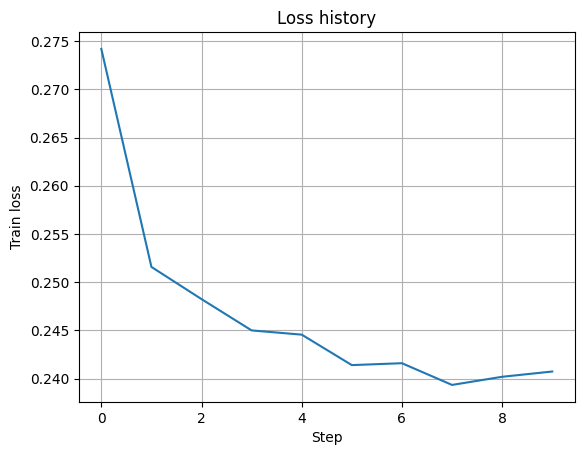

In [ ]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)

#### Визуализация эмбеддингов

**Bokeh** is a Python library for creating interactive visualizations for modern web browsers. It helps you build beautiful graphics, ranging from simple plots to complex dashboards with streaming datasets. With Bokeh, you can create JavaScript-powered visualizations without writing any JavaScript yourself.

[Bokeh docs](https://docs.bokeh.org/en/latest/)

[Bokeh vs Plotly](https://buggyprogrammer.com/bokeh-vs-plotly-which-one-is-better-in-2022/)

In [ ]:
!pip install -qq bokeh

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

[tSNE comparison](https://gist.github.com/kylemcdonald/c25c64dabdfd21ca8ab0e23b8e559061)

In [ ]:
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100, n_iter=400)
    return tsne.fit_transform(word_vectors)


def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [ ]:
val_dataset[0]

([44, 15, 50, 37, 16, 9], 0)

In [ ]:
test_data[:10]

['учёбой',
 'допросы',
 'перегруженности',
 'изготовителем',
 'материальностью',
 'депо',
 'силикаты',
 'тривиальности',
 'маскам',
 'клементин']

In [ ]:
word_indices = np.random.choice(np.arange(len(test_data)), 200, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]

word_tensor = []
for word in words:
  word_tensor.append([char2id.get(c, 0) for c in word])

In [ ]:
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()
embeddings.shape

(51, 30)

In [ ]:
word_embeddings = np.array([embeddings[c_indices].mean(0) for c_indices in word_tensor])
word_embeddings.shape

(200, 30)

In [ ]:
colors = ['red' if label else 'blue' for label in labels]
visualize_embeddings(word_embeddings, words, colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.540863
[t-SNE] Computed conditional probabilities in 0.010s
[t-SNE] Iteration 50: error = 58.2493820, gradient norm = 0.2595385 (50 iterations in 4.028s)
[t-SNE] Iteration 100: error = 58.9819565, gradient norm = 0.3985726 (50 iterations in 2.658s)
[t-SNE] Iteration 150: error = 57.5485916, gradient norm = 0.4775189 (50 iterations in 3.311s)
[t-SNE] Iteration 200: error = 60.6706772, gradient norm = 0.2422106 (50 iterations in 4.419s)
[t-SNE] Iteration 250: error = 58.9846306, gradient norm = 0.2941484 (50 iterations in 4.813s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.984631
[t-SNE] Iteration 300: error = 1.0122905, gradient norm = 0.0068707 (50 iterations in 4.440s)
[t-SNE] Iteration 350: error = 0.9870756, gradient norm = 0.0014582 (

### CNN Text Classification

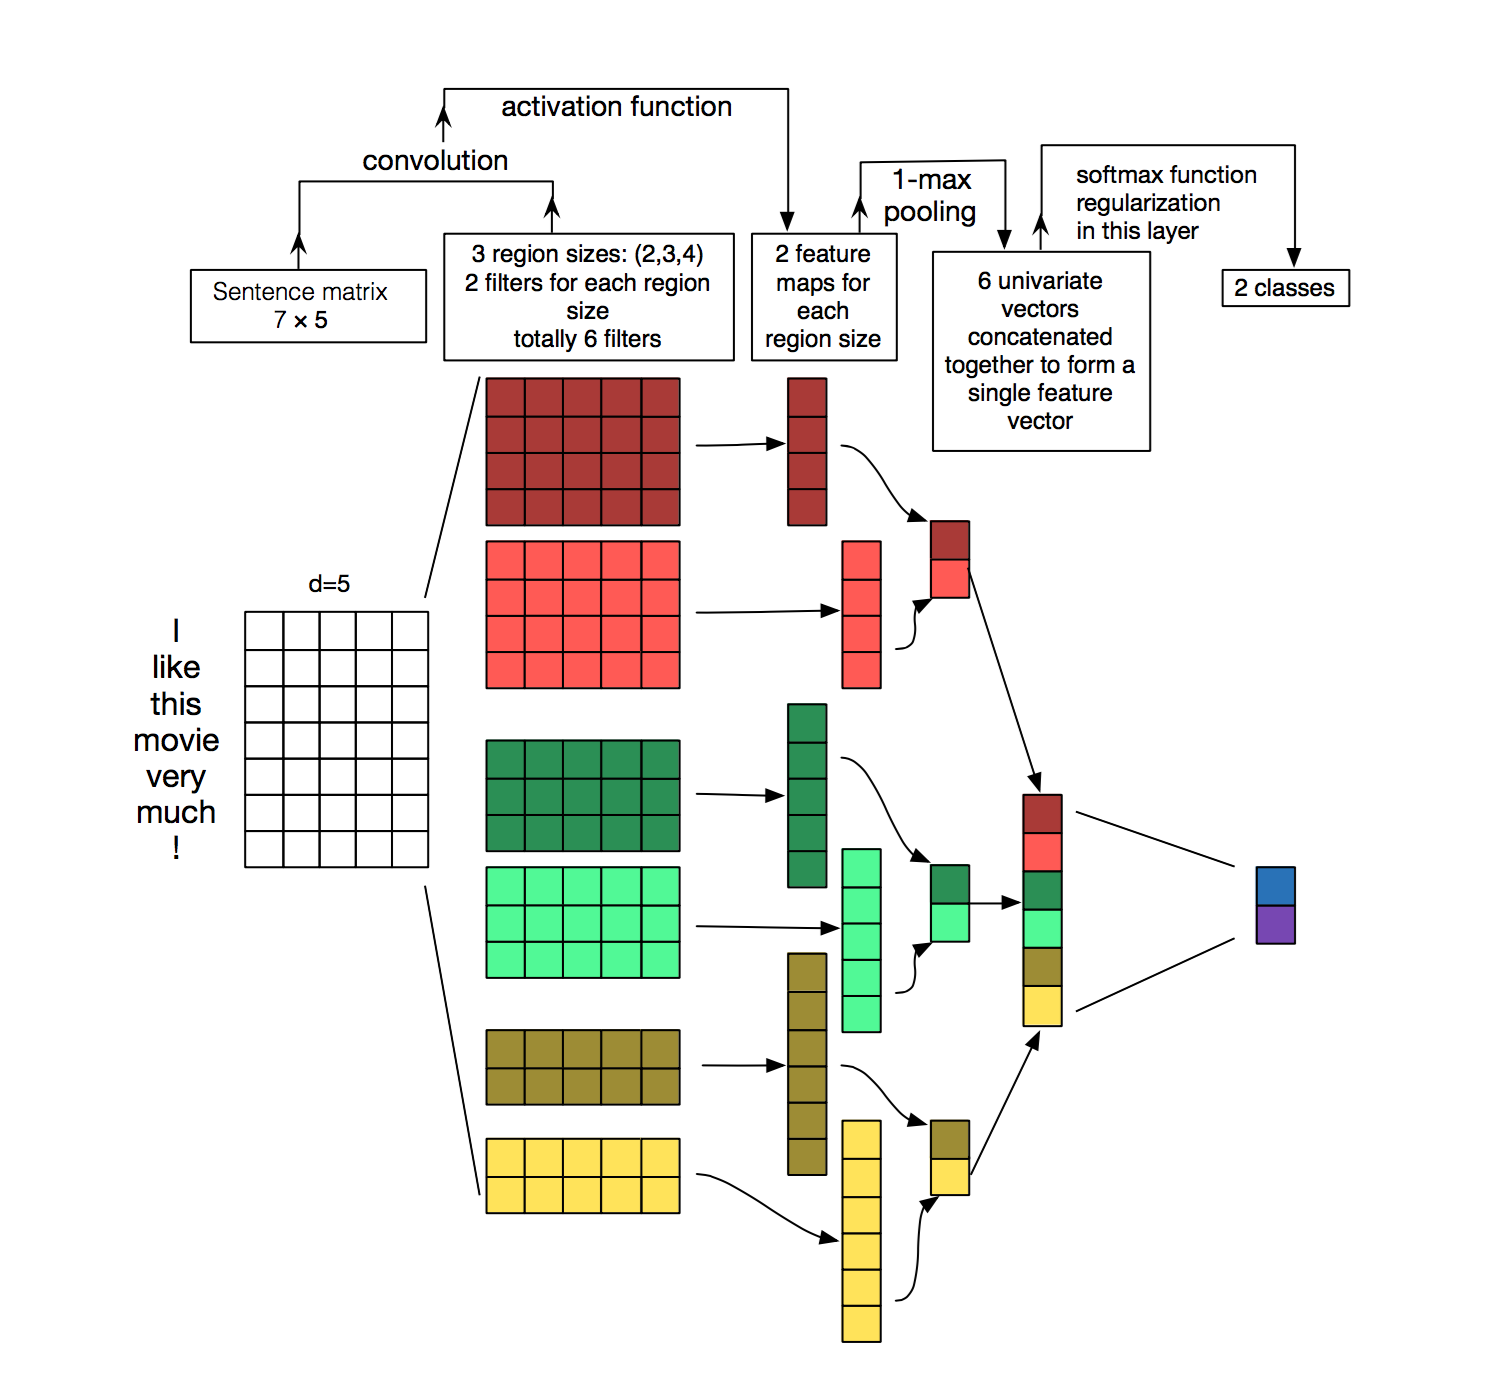

#### Данные & предобработка

In [ ]:
base_url = "https://github.com/madrugado/keras-tutorial/raw/master/data"
df_train = pd.read_csv(f"{base_url}/train.csv")
df_test = pd.read_csv(f"{base_url}/test.csv")
df_val = pd.read_csv(f"{base_url}/val.csv")

In [ ]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [ ]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [ ]:
train_corpus = list(df_train["text"])

In [ ]:
'hello    world'.split()

['hello', 'world']

In [ ]:
tokens = []
for text in tqdm(train_corpus):
  tokens.extend(word_tokenize(text))
tokens_filtered = [word for word in tokens if word.isalnum()]

  0%|          | 0/181467 [00:00<?, ?it/s]

In [ ]:
from nltk.probability import FreqDist

In [ ]:
max_words = 2000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [ ]:
tokens_filtered_top[:10]

['не', 'и', 'я', 'в', 'RT', 'на', 'http', 'что', 'с', 'а']

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
len(vocabulary)

1999

In [ ]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [ ]:
max_len = 40
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(df_train["text"])], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(df_test["text"])], dtype=np.int32)
x_val = np.array([text_to_sequence(text, max_len) for text in tqdm(df_val["text"])], dtype=np.int32)

  0%|          | 0/181467 [00:00<?, ?it/s]

  0%|          | 0/22684 [00:00<?, ?it/s]

  0%|          | 0/22683 [00:00<?, ?it/s]

In [ ]:
x_train.shape

(181467, 40)

In [ ]:
y_train = np.array(df_train["class"])
y_val = np.array(df_val["class"])

#### Обучение модели

In [ ]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [ ]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
batch_size = 256
epochs = 10

model = ConvTextClassifier()
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TextDataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []
    temp_metrics = []
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data
        target = target
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

ConvTextClassifier(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 305538
Train epoch 1/10
Loss: 0.6026146633836883, f1 score: 0.683224703928742
Train epoch 2/10
Loss: 0.5566521271832067, f1 score: 0.721888013720008
Train epoch 3/10
Loss: 0.5369645481973845, f1 score: 0.7348345708107242
Train epoch 4/10
Loss: 0.5207040155219763, f1 score: 0.7470398565441664
Train epoch 5/10
Loss: 0.5045455966160564, f1 score: 0.7567483358221767
Train epoch 6/10
Loss: 0.487206302425589, f1 score: 0.7676662247002713
Train epoch 7/10
Loss: 0.47348114864950624, f1 score: 0.7753498723207644
Train epoch 8/10
Loss: 0.45928185379555597, f1 score: 0.7831228011417792
Train epoch 9/10
Loss: 0.4422026556957256, f1 score: 0.7916833471680226
Train epoch 10/10
Loss: 0.4333043016062469, f1 score: 0.7974806233757138


#### Инициализация предобученными эмбеддингами

In [ ]:
!pip install fasttext

In [ ]:
import fasttext.util

In [ ]:
def load_pretrained_vectors(word2idx, model):

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), model.get_dimension()))
    embeddings[word2idx['<pad>']] = np.zeros((model.get_dimension(),))

    count = 0
    for word, index in word2idx.items():
        embeddings[index] = model.get_word_vector(word)
        count += 1

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    return embeddings

In [ ]:
%%bash
wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz .
gunzip cc.ru.300.bin.gz

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')
vocabulary['<pad>'] = 0
embeddings = load_pretrained_vectors(vocabulary, ft)

There are 2000 / 2000 pretrained vectors found.


In [ ]:
embeddings.shape

(2000, 300)

In [ ]:
class ConvTextClassifierPretrainedW2V(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embeddings, dtype=torch.float32))
        self.embedding.weight.requires_grad = True # static vs non-static
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [ ]:
model = ConvTextClassifierPretrainedW2V(embedding_dim=300)

In [ ]:
batch_size = 256
epochs = 10

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TextDataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []
    temp_metrics = []
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data
        target = target
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()
    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')

ConvTextClassifierPretrainedW2V(
  (embedding): Embedding(2000, 300)
  (conv): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 715586
Train epoch 1/10
Loss: 0.5830694129335864, f1 score: 0.6998490040231239
Train epoch 2/10
Loss: 0.5568472575317485, f1 score: 0.7223310114130147
Train epoch 3/10
Loss: 0.5440098791263672, f1 score: 0.7300230988494432
Train epoch 4/10
Loss: 0.5302499692850288, f1 score: 0.738966238179227
Train epoch 5/10
Loss: 0.5185829601519871, f1 score: 0.7438826814861325
Train epoch 6/10
Loss: 0.5093530557303569, f1 score: 0.748494339762689
Train epoch 7/10
Loss: 0.4998764351577786, f1 score: 0.7557718787442141
Train epoch 8/10
Loss: 0.4919198382808728, f1 score: 0.7586280118427088
Train epoch 9/10
Loss: 0.48272940827525723, f1 score: 0.764878137911997
Train epoch 10/10
Loss: 0.4752946271126294, f1 score: 0.7692604578600616


### Что еще почитать?

[Демистифицируем свёрточные нейросети](https://habr.com/ru/company/nix/blog/443236/)

[Применение сверточных нейронных сетей для задач NLP](https://habr.com/ru/company/ods/blog/353060/)

[Анализ тональности текстов с помощью сверточных нейронных сетей](https://habr.com/ru/company/vk/blog/417767/)

[Understanding Convolutional Neural Networks for NLP, Denny Britz](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

[Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

[A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification Zhang et al., 2015](https://arxiv.org/abs/1510.03820)

[Learning Character-level Representations for Part-of-Speech Tagging, dos Santos et al, 2014](http://proceedings.mlr.press/v32/santos14.pdf)

______

[cs224n "Lecture 13: Convolutional Neural Networks"](https://www.youtube.com/watch?v=Lg6MZw_OOLI)

[Deep Learning for NLP - Lecture 5 - Convolutional Neural Networks](https://www.youtube.com/watch?v=nzSPZyjGlWI)